# Parking Lot Occupancy Estimation - Training

This notebook trains deep learning models for parking lot occupancy estimation.

**Authors:** Aminu Yiwere, Olatunji Olagundoye
**Date:** November 5, 2025  
**Environment:** Google Colab

---


## 1. Setup and Installation

Install required packages and mount Google Drive (if using Colab)


In [2]:
# Check if running on Colab and mount Google Drive
import sys
sys.path.append('/content/drive/MyDrive/pvseg/ultralytics')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataset_url = '/content/drive/MyDrive/Car Park.v6-final-dataset1.yolov11'

In [ ]:
# Install required packages


## 2. Import Libraries


In [5]:
# Import all necessary libraries
import os
import yaml
from ultralytics import YOLO
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from PIL import Image
import shutil

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 3. Configuration and Hyperparameters


In [6]:
# Define configuration and hyperparameters
config = {
    'dataset_path': dataset_url,  # Path to dataset
    'data_yaml': os.path.join(dataset_url, 'data.yaml'),  # Path to data.yaml
    'model_name': 'yolov11m.pt',  # YOLOv11 nano (options: yolov11n, yolov11s, yolov11m)
    'epochs': 100,
    'batch_size': 16,
    'img_size': 640,
    'patience': 20,  # Early stopping patience
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'project': 'parking_lot_detection',
    'name': 'yolov11n_training',
    'save_dir': '/content/drive/MyDrive/parking_results'
}

print(f"Configuration:")
print(f"  Device: {config['device']}")
print(f"  Model: {config['model_name']}")
print(f"  Epochs: {config['epochs']}")
print(f"  Batch Size: {config['batch_size']}")
print(f"  Image Size: {config['img_size']}")
print(f"  Dataset: {config['dataset_path']}")

Configuration:
  Device: cuda
  Model: yolov11m.pt
  Epochs: 100
  Batch Size: 16
  Image Size: 640
  Dataset: /content/drive/MyDrive/Car Park.v6-final-dataset1.yolov11


## 4. Dataset Class and Data Augmentation


In [7]:
# YOLOv11 handles dataset loading internally
# No need to define custom dataset class - YOLO uses the data.yaml configuration
print("Dataset will be loaded automatically by YOLO using data.yaml")

Dataset will be loaded automatically by YOLO using data.yaml


In [8]:
# YOLOv11 includes built-in augmentations
# Augmentation parameters are configured in the training call
print("Augmentation settings will be applied during training")

Augmentation settings will be applied during training


## 5. Load and Explore Dataset


In [9]:
# Verify dataset structure and data.yaml
print("Verifying dataset structure...")
print(f"\nDataset path exists: {os.path.exists(config['dataset_path'])}")
print(f"data.yaml exists: {os.path.exists(config['data_yaml'])}")

# List directory contents
if os.path.exists(config['dataset_path']):
    print(f"\nDataset contents:")
    for item in os.listdir(config['dataset_path']):
        item_path = os.path.join(config['dataset_path'], item)
        if os.path.isdir(item_path):
            num_files = len(os.listdir(item_path)) if os.path.exists(item_path) else 0
            print(f"  {item}/ ({num_files} items)")
        else:
            print(f"  {item}")

# Read and display data.yaml
if os.path.exists(config['data_yaml']):
    print("\ndata.yaml contents:")
    with open(config['data_yaml'], 'r') as f:
        data_config = yaml.safe_load(f)
        print(yaml.dump(data_config, default_flow_style=False))

Verifying dataset structure...

Dataset path exists: True
data.yaml exists: True

Dataset contents:
  .DS_Store
  train/ (3 items)
  test/ (3 items)
  valid/ (3 items)
  README.dataset.txt
  data.yaml
  README.roboflow.txt

data.yaml contents:
names:
- car
- lot_boundary
- objects
- stall
nc: 4
roboflow:
  license: CC BY 4.0
  project: car-park-x0jof
  url: https://universe.roboflow.com/ay-luu4n/car-park-x0jof/dataset/6
  version: 6
  workspace: ay-luu4n
test: ../test/images
train: ../train/images
val: ../valid/images



Classes: ['car', 'lot_boundary', 'objects', 'stall']


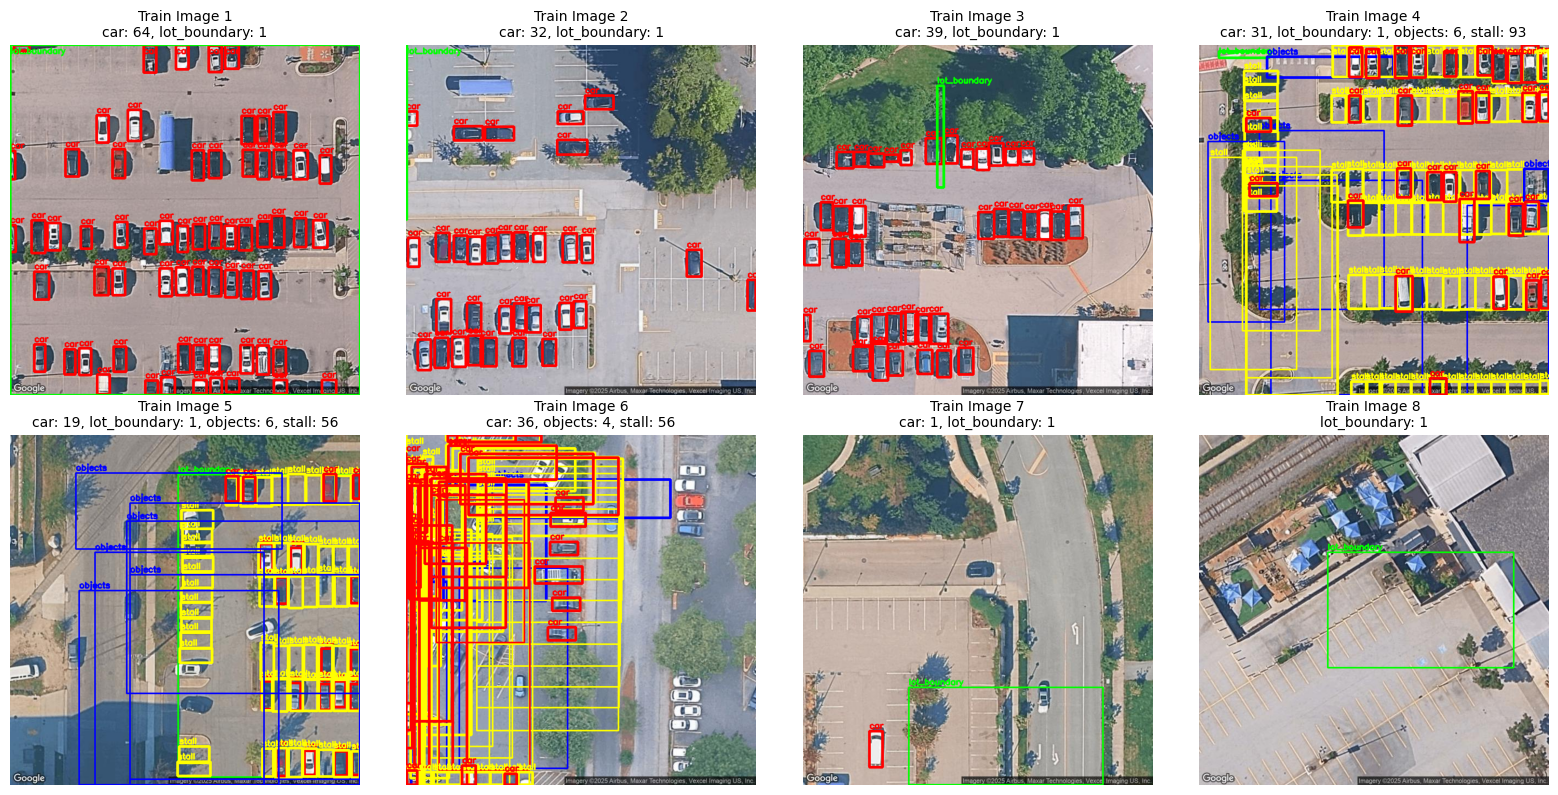


Total images in train set: 115
Class colors: car: Red, lot_boundary: Green, objects: Blue, stall: Yellow


In [13]:
# Visualize sample images from dataset
def visualize_samples(dataset_path, split='train', num_samples=8):
    """Visualize sample images with their annotations"""
    images_dir = os.path.join(dataset_path, split, 'images')
    labels_dir = os.path.join(dataset_path, split, 'labels')

    if not os.path.exists(images_dir):
        print(f"Images directory not found: {images_dir}")
        return

    # Get class names from data.yaml
    data_yaml_path = os.path.join(dataset_path, 'data.yaml')
    class_names = ['class_0', 'class_1', 'class_2', 'class_3']  # Default
    if os.path.exists(data_yaml_path):
        with open(data_yaml_path, 'r') as f:
            data_config = yaml.safe_load(f)
            if 'names' in data_config:
                class_names = data_config['names']

    print(f"Classes: {class_names}")

    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    num_samples = min(num_samples, len(image_files))

    # Calculate grid size for subplots
    n_cols = 4  # Number of columns
    n_rows = (num_samples + n_cols - 1) // n_cols # Calculate rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for idx in range(num_samples):
        img_file = image_files[idx]
        img_path = os.path.join(images_dir, img_file)
        label_path = os.path.join(labels_dir, img_file.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt'))

        # Read image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # Statistics for this image
        bbox_stats = {name: 0 for name in class_names}

        # Read and draw bounding boxes
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    line = line.strip()
                    if not line:  # Skip empty lines
                        continue

                    # Split and parse the line
                    parts = line.split()
                    if len(parts) < 5:  # Need at least class_id + 4 bbox values
                        continue

                    # Extract the first 5 values (class_id, x_center, y_center, width, height)
                    class_id = int(float(parts[0]))
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])

                    # Count this class
                    if class_id < len(class_names):
                        bbox_stats[class_names[class_id]] += 1

                    # Validate coordinates are in [0, 1] range
                    if not (0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 < width <= 1 and 0 < height <= 1):
                        print(f"Warning: Invalid coordinates in {img_file}: class={class_id}, x={x_center}, y={y_center}, w={width}, h={height}")

                    # Convert YOLO format to pixel coordinates
                    x1 = int((x_center - width/2) * w)
                    y1 = int((y_center - height/2) * h)
                    x2 = int((x_center + width/2) * w)
                    y2 = int((y_center + height/2) * h)

                    # Clip coordinates to image boundaries
                    x1 = max(0, min(x1, w-1))
                    y1 = max(0, min(y1, h-1))
                    x2 = max(0, min(x2, w-1))
                    y2 = max(0, min(y2, h-1))


                    # Different colors and thickness for each class
                    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]  # Red, Green, Blue, Yellow
                    color = colors[class_id % len(colors)]

                    # Use thicker lines for smaller objects
                    thickness = 3 if width * height < 0.1 else 2

                    # Draw rectangle
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)

                    # Add class label
                    if class_id < len(class_names):
                        label_text = class_names[class_id]
                        # Put label above the box
                        label_y = max(y1 - 5, 15)
                        cv2.putText(img, label_text, (x1, label_y),
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        axes[idx].imshow(img)

        # Create title with bbox counts
        stats_str = ', '.join([f"{name}: {count}" for name, count in bbox_stats.items() if count > 0])
        axes[idx].set_title(f'{split.capitalize()} Image {idx+1}\n{stats_str}', fontsize=10)
        axes[idx].axis('off')

    # Hide any unused subplots
    for idx in range(num_samples, len(axes)):
        axes[idx].axis('off')


    plt.tight_layout()
    plt.show()

    print(f"\nTotal images in {split} set: {len(image_files)}")
    print(f"Class colors: {', '.join([f'{class_names[i]}: {c}' for i, c in enumerate(['Red', 'Green', 'Blue', 'Yellow'])])}")

# Visualize training samples
visualize_samples(config['dataset_path'], 'train', num_samples=8)

In [ ]:
# Inspect a sample annotation file in detail
train_labels_dir = os.path.join(config['dataset_path'], 'train', 'labels')
label_files = [f for f in os.listdir(train_labels_dir) if f.endswith('.txt')]

if label_files:
    sample_label = os.path.join(train_labels_dir, label_files[0])
    print(f"Inspecting: {label_files[0]}")
    print("="*60)

    with open(sample_label, 'r') as f:
        lines = f.readlines()
        print(f"Total annotations: {len(lines)}\n")

        # Count by class
        class_counts = {}
        for line in lines:
            parts = line.strip().split()
            if parts:
                class_id = int(float(parts[0]))
                class_counts[class_id] = class_counts.get(class_id, 0) + 1

        print("Annotations per class:")
        for class_id, count in sorted(class_counts.items()):
            print(f"  Class {class_id}: {count} objects")

        print("\nFirst 5 annotations:")
        for i, line in enumerate(lines[:5]):
            parts = line.strip().split()
            if len(parts) >= 5:
                print(f"  {i+1}. Class: {parts[0]}, x_center: {parts[1]}, y_center: {parts[2]}, width: {parts[3]}, height: {parts[4]}")

                # Check if values are in valid range
                x, y, w, h = map(float, parts[1:5])
                if not (0 <= x <= 1 and 0 <= y <= 1 and 0 < w <= 1 and 0 < h <= 1):
                    print(f"     WARNING: Values out of range [0, 1]!")


## 6. Model Architecture


In [ ]:
# Load YOLOv11 model
print(f"Loading {config['model_name']} model...")
model = YOLO(config['model_name'])

# Model summary
print("\nModel loaded successfully!")
print(f"Model type: {type(model)}")
print(f"Device: {config['device']}")

## 7. Loss Function and Optimizer


In [ ]:
# YOLOv11 uses built-in loss functions and optimizer
# Loss: Combination of box regression, objectness, and classification loss
# Optimizer: Adam (as specified in configuration)
# These are handled automatically by the Ultralytics framework
print("Loss function: YOLO loss (box + objectness + classification)")
print("Optimizer: Adam")
print("Learning rate schedule: Cosine annealing with warmup")

## 8. Training and Validation Functions


In [ ]:
# YOLOv11 handles training and validation internally
# The model.train() method includes:
# - Training loop with gradient updates
# - Validation after each epoch
# - Early stopping based on patience
# - Model checkpointing (best and last weights)
# - Automatic metric calculation (mAP, precision, recall, F1)
print("Training and validation are handled by YOLO's built-in training pipeline")

## 9. Training Loop


In [ ]:
# Train the model
print("Starting training...")
print("="*50)

results = model.train(
    data=config['data_yaml'],
    epochs=config['epochs'],
    imgsz=config['img_size'],
    batch=config['batch_size'],
    device=config['device'],
    project=config['project'],
    name=config['name'],
    patience=config['patience'],
    save=True,
    plots=True,
    verbose=True,
    val=True,
    # Optimizer settings (Adam as per proposal)
    optimizer='Adam',
    lr0=0.01,  # Initial learning rate
    lrf=0.01,  # Final learning rate
    # Augmentation settings
    mosaic=1.0,
    mixup=0.0,
    hsv_h=0.015,  # HSV-Hue augmentation
    hsv_s=0.7,    # HSV-Saturation augmentation
    hsv_v=0.4,    # HSV-Value augmentation
    degrees=0.0,  # Rotation
    translate=0.1,
    scale=0.5,
    fliplr=0.5,   # Horizontal flip
)

print("\n" + "="*50)
print("Training completed!")

## 10. Plot Training History


In [ ]:
# Display training results
print("Training Results Summary:")
print("="*50)

# Get the results directory
results_dir = os.path.join(config['project'], config['name'])

if os.path.exists(results_dir):
    print(f"\nResults saved to: {results_dir}")

    # Display training plots
    plots = ['results.png', 'confusion_matrix.png', 'F1_curve.png', 'PR_curve.png', 'P_curve.png', 'R_curve.png']

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()

    for idx, plot_name in enumerate(plots):
        plot_path = os.path.join(results_dir, plot_name)
        if os.path.exists(plot_path):
            img = plt.imread(plot_path)
            axes[idx].imshow(img)
            axes[idx].set_title(plot_name.replace('.png', '').replace('_', ' ').title())
            axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, f'{plot_name}\nNot Available',
                          ha='center', va='center', fontsize=12)
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    # Display best model metrics
    if hasattr(results, 'results_dict'):
        print("\nBest Model Metrics:")
        for key, value in results.results_dict.items():
            if isinstance(value, (int, float)):
                print(f"  {key}: {value:.4f}")
else:
    print(f"Results directory not found: {results_dir}")

## 11. Save Final Results


In [ ]:
# Save final results to Google Drive
print("Saving results to Google Drive...")

# Create save directory
os.makedirs(config['save_dir'], exist_ok=True)

# Copy best model
results_dir = os.path.join(config['project'], config['name'])
best_model_path = os.path.join(results_dir, 'weights', 'best.pt')
last_model_path = os.path.join(results_dir, 'weights', 'last.pt')

if os.path.exists(best_model_path):
    shutil.copy(best_model_path, os.path.join(config['save_dir'], 'best.pt'))
    print(f"✓ Saved best model to {config['save_dir']}/best.pt")

if os.path.exists(last_model_path):
    shutil.copy(last_model_path, os.path.join(config['save_dir'], 'last.pt'))
    print(f"✓ Saved last model to {config['save_dir']}/last.pt")

# Copy results plots
if os.path.exists(results_dir):
    for file in os.listdir(results_dir):
        if file.endswith('.png') or file.endswith('.csv'):
            src = os.path.join(results_dir, file)
            dst = os.path.join(config['save_dir'], file)
            shutil.copy(src, dst)
    print(f"✓ Saved plots and results to {config['save_dir']}")

print("\n" + "="*50)
print("All results saved successfully!")
print(f"Check Google Drive: {config['save_dir']}")
print("="*50)

## 12. Test Model on Sample Images


In [ ]:
# Load best model and run inference on test images
best_model = YOLO(os.path.join(config['save_dir'], 'best.pt'))

# Get test images
test_images_dir = os.path.join(config['dataset_path'], 'test', 'images')
test_images = [os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))][:4]

print(f"Testing on {len(test_images)} sample images...")

# Run inference
results = best_model(test_images, conf=0.25, iou=0.45)

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

for idx, (result, img_path) in enumerate(zip(results, test_images)):
    # Plot the result
    img_with_boxes = result.plot()

    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

    axes[idx].imshow(img_rgb)
    axes[idx].set_title(f'Test Image {idx+1} - Detections: {len(result.boxes)}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Print detection statistics
print("\nDetection Statistics:")
for idx, result in enumerate(results):
    print(f"\nImage {idx+1}:")
    if len(result.boxes) > 0:
        classes = result.boxes.cls.cpu().numpy()
        confidences = result.boxes.conf.cpu().numpy()

        # Count detections per class
        unique_classes, counts = np.unique(classes, return_counts=True)
        class_names = result.names

        for cls, count in zip(unique_classes, counts):
            print(f"  {class_names[int(cls)]}: {count} detections")
        print(f"  Average confidence: {confidences.mean():.3f}")
    else:
        print("  No detections")